In [55]:
import os, json, joblib, warnings, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.base import BaseEstimator, RegressorMixin

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBRegressor
from tensorflow.keras import layers, callbacks, models as tf_models
from pathlib import Path

warnings.filterwarnings("ignore")

pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 100)

ROOT = Path(os.path.abspath(os.path.join(os.getcwd(), "..")))

DATA_DIR   = ROOT / "data" / "clean_data"
RAW_DIR    = ROOT / "data" / "raw_data"
EDA_DIR    = ROOT / "EDA"
MODELS_DIR = ROOT / "models"
ART_DIR    = ROOT / "artifacts"
FIG_DIR    = ART_DIR / "figures"
MET_DIR    = ART_DIR / "metrics"

DATA_CSV = DATA_DIR / "spotify_features.csv"

for d in [ART_DIR, FIG_DIR, MET_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("DATA_DIR:", DATA_DIR)
print("Using dataset:", DATA_CSV)
print("MODELS_DIR:", MODELS_DIR)
print("ARTIFACTS_DIR:", ART_DIR)


ROOT: C:\DS\spotify-MRS
DATA_DIR: C:\DS\spotify-MRS\data\clean_data
Using dataset: C:\DS\spotify-MRS\data\clean_data\spotify_features.csv
MODELS_DIR: C:\DS\spotify-MRS\models
ARTIFACTS_DIR: C:\DS\spotify-MRS\artifacts


**Load & train/test**

In [26]:
df = pd.read_csv(DATA_CSV)
y = df["popularity"].astype(float)
X = df.drop(columns = [c for c in ["popularity", "popular_flag"] if c in df.columns])
print("X shape:", X.shape, "| y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, MODELS_DIR / "scaler.joblib")
print("Saved scaler ->", MODELS_DIR / "scaler.joblib")

X shape: (130326, 50) | y shape: (130326,)
Saved scaler -> C:\DS\spotify-MRS\models\scaler.joblib


In [27]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha = 1.0, random_state = 42),
    "Lasso": Lasso(alpha = 0.001, random_state = 42, max_iter = 1000),
    "RandomForestRegressor": RandomForestRegressor(n_estimators = 350, random_state = 42, n_jobs = -1),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state = 42, n_estimators = 400, learning_rate = 0.05, max_depth = 3),
    "MLPRegressor": MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation="relu", solver="adam", learning_rate_init=0.001, max_iter=500, random_state=42, early_stopping=True, validation_fraction=0.1),
    "XGBoost": XGBRegressor(n_estimators=600, learning_rate=0.05, max_depth=6, subsample=0.8,colsample_bytree=0.8, reg_alpha=0.0, reg_lambda=1.0, random_state=42, n_jobs=-1, tree_method="hist"
    )
}

def eval_metrics(y_true, y_pred):
    return {
        "R2": round(float(r2_score(y_true, y_pred)), 4),
        "MAE": round(float(mean_absolute_error(y_true, y_pred)), 4),
        "RMSE": round(float(mean_squared_error(y_true, y_pred)), 4),
    }

results = {}
fitted_models = {}
for name, est in models.items():
    est.fit(X_train_scaled, y_train)
    pred = est.predict(X_test_scaled)
    met = eval_metrics(y_test, pred)
    results[name] = met
    fitted_models[name] = (est, pred)
    joblib.dump(est, MODELS_DIR / f"{name}.joblib")
    print(f"{name:16s} -> R2: {met['R2']: > 6.3f} | MAE: {met['MAE']: > 7.3f} | RMSE: {met['RMSE']:>7.3f}")

results_df = pd.DataFrame(results).T.sort_values("RMSE").reset_index().rename(columns={"index":"model"})
results_df.to_csv(MET_DIR / "model_comparison.csv", index=False)
with open(MET_DIR / "model_comparison.json", "w") as f:
    json.dump(results, f, indent = 2)

display(results_df)
print("Saved metrics ->", MET_DIR / "model_comparison.csv")

LinearRegression -> R2:  0.167 | MAE:  14.765 | RMSE: 318.865
Ridge            -> R2:  0.167 | MAE:  14.765 | RMSE: 318.864
Lasso            -> R2:  0.167 | MAE:  14.766 | RMSE: 318.854
RandomForestRegressor -> R2:  0.214 | MAE:  14.125 | RMSE: 300.870
GradientBoostingRegressor -> R2:  0.199 | MAE:  14.418 | RMSE: 306.749
MLPRegressor     -> R2:  0.200 | MAE:  14.325 | RMSE: 306.087
XGBoost          -> R2:  0.220 | MAE:  14.099 | RMSE: 298.705


,model,R2,MAE,RMSE
0,XGBoost,0.2195,14.0989,298.7050
1,RandomForestRegressor,0.2139,14.1251,300.8702
2,MLPRegressor,0.2003,14.3253,306.0866
3,GradientBoostingRegressor,0.1985,14.4185,306.7486
4,Lasso,0.1669,14.7658,318.8543
5,Ridge,0.1669,14.7654,318.8639
6,LinearRegression,0.1669,14.7654,318.8646


Saved metrics -> C:\DS\spotify-MRS\artifacts\metrics\model_comparison.csv


**Comparison chart/Best model**

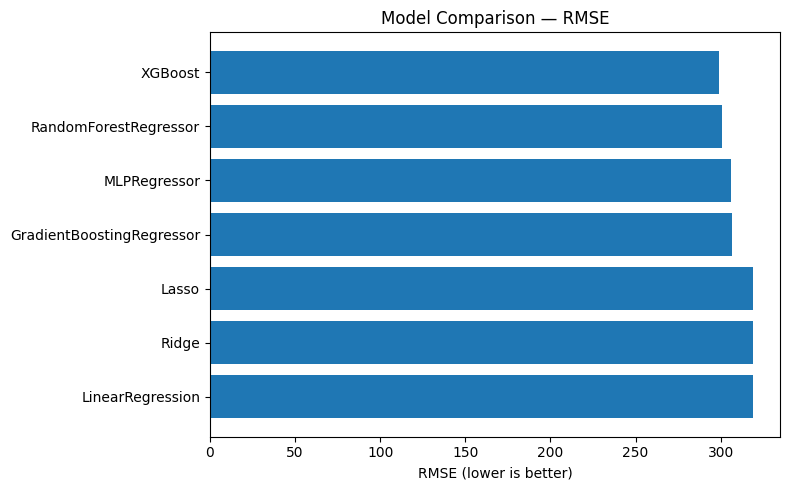

Best model: XGBoost | RMSE=298.705 | R2=0.2195 | MAE=14.0989


In [28]:
plt.figure(figsize=(8,5))
plt.barh(results_df["model"][::-1], results_df["RMSE"][::-1])
plt.xlabel("RMSE (lower is better)")
plt.title("Model Comparison — RMSE")
plt.tight_layout()
plt.savefig(FIG_DIR / "model_comparison_rmse.png", dpi=200)
plt.show()

best_row = results_df.iloc[0]
best_name = best_row["model"]
best_est, best_preds = fitted_models[best_name]
print(f"Best model: {best_name} | RMSE={best_row['RMSE']} | R2={best_row['R2']} | MAE={best_row['MAE']}")

**Predicted VS Actual**

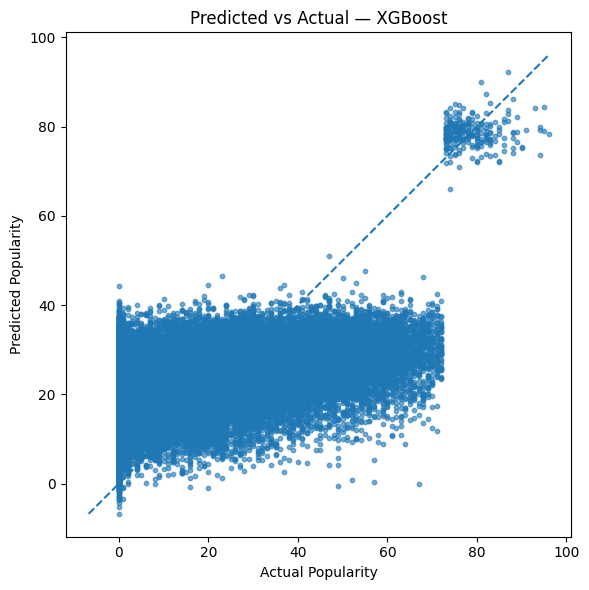

Saved predictions -> C:\DS\spotify-MRS\artifacts\metrics\predictions_XGBoost.csv


In [29]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_preds, s=10, alpha=0.6)
lims = [min(y_test.min(), best_preds.min()), max(y_test.max(), best_preds.max())]
plt.plot(lims, lims, linestyle="--")
plt.xlabel("Actual Popularity")
plt.ylabel("Predicted Popularity")
plt.title(f"Predicted vs Actual — {best_name}")
plt.tight_layout()
plt.savefig(FIG_DIR / f"pred_vs_actual_{best_name}.png", dpi=200)
plt.show()

pred_out = pd.DataFrame({
    "y_test": y_test.values,
    "y_pred": best_preds
})
pred_out.to_csv(MET_DIR / f"predictions_{best_name}.csv", index=False)
print("Saved predictions ->", MET_DIR / f"predictions_{best_name}.csv")

**Feature importance**

Saved importances -> C:\DS\spotify-MRS\artifacts\metrics\feature_importance_XGBoost.csv


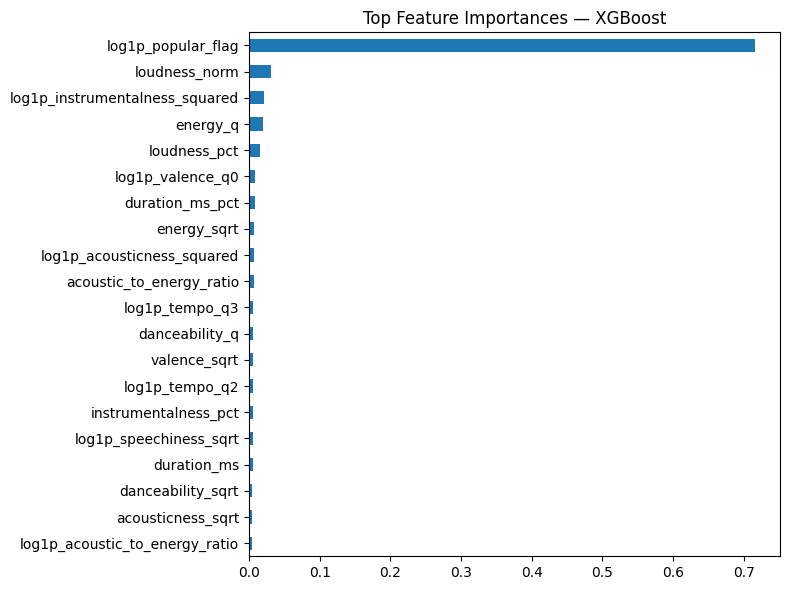

In [30]:
feature_names = X.columns.tolist()

def save_tree_importances(name, est):
    if hasattr(est, "feature_importances_"):
        imp = pd.Series(est.feature_importances_, index=feature_names).sort_values(ascending=False)
        out_csv = MET_DIR / f"feature_importance_{name}.csv"
        imp.to_csv(out_csv, header=["importance"])
        print(f"Saved importances -> {out_csv}")

        plt.figure(figsize=(8,6))
        imp.head(20).sort_values().plot(kind="barh")
        plt.title(f"Top Feature Importances — {name}")
        plt.tight_layout()
        plt.savefig(FIG_DIR / f"feature_importance_{name}.png", dpi=200)
        plt.show()

for name in ["RandomForest","GradientBoosting","XGBoost"]:
    if name in fitted_models:
        save_tree_importances(name, fitted_models[name][0])


**Neural Network**

In [37]:
input_dim = X_train_scaled.shape[1]
print("Neural Network input_dim:", input_dim)
nn = tf_models.Sequential([
    layers.Input(shape = (input_dim,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(1)
])
nn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = "mse", metrics = ["mae"])
es = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)

history = nn.fit(X_train_scaled, y_train, validation_split = 0.2, epochs = 60, batch_size = 64, callbacks = [es, rlr], verbose = 1)
nn_path = MODELS_DIR / "NeuralNet.keras"
nn.save(nn_path)

Neural Network input_dim: 50
Epoch 1/60
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 338.6759 - mae: 15.0508 - val_loss: 315.7162 - val_mae: 14.6925 - learning_rate: 0.0010
Epoch 2/60
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 318.3493 - mae: 14.6767 - val_loss: 311.6057 - val_mae: 14.5536 - learning_rate: 0.0010
Epoch 3/60
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 315.9959 - mae: 14.6043 - val_loss: 310.5564 - val_mae: 14.5548 - learning_rate: 0.0010
Epoch 4/60
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 314.5818 - mae: 14.5731 - val_loss: 310.3961 - val_mae: 14.5685 - learning_rate: 0.0010
Epoch 5/60
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 312.7445 - mae: 14.5295 - val_loss: 310.1555 - val_mae: 14.5377 - learning_rate: 0.0010
Epoch 6/60
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 312.6783 - mae: 14.5046 - val_loss: 309.4558 - val_mae: 14.4799 - learning_rate: 0.0010
Epoch 7/60
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 312.1616 

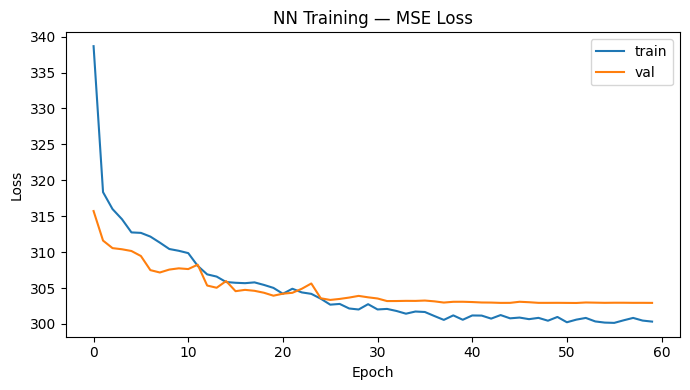

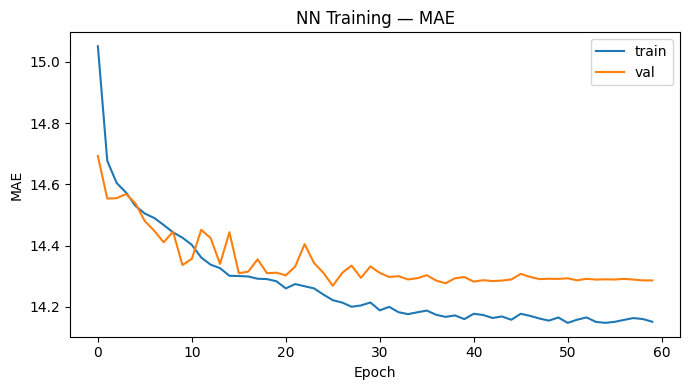

In [38]:
hist = history.history

plt.figure(figsize=(7,4))
plt.plot(hist["loss"], label="train")
plt.plot(hist["val_loss"], label="val")
plt.title("NN Training — MSE Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR / "nn_train_val_loss.png", dpi=200)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(hist["mae"], label="train")
plt.plot(hist["val_mae"], label="val")
plt.title("NN Training — MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE")
plt.legend(); plt.tight_layout()
plt.savefig(FIG_DIR / "nn_train_val_mae.png", dpi=200)
plt.show()

**Evaluate/predict**

NeuralNet -> R2: 0.2048 | MAE: 14.3073 | RMSE: 304.3568


,Model,R2,MAE,RMSE
0,XGBoost,0.2195,14.0989,298.7050
1,RandomForestRegressor,0.2139,14.1251,300.8702
2,NeuralNet,0.2048,14.3073,304.3568
3,MLPRegressor,0.2003,14.3253,306.0866
4,GradientBoostingRegressor,0.1985,14.4185,306.7486
5,Lasso,0.1669,14.7658,318.8543
6,Ridge,0.1669,14.7654,318.8639
7,LinearRegression,0.1669,14.7654,318.8646


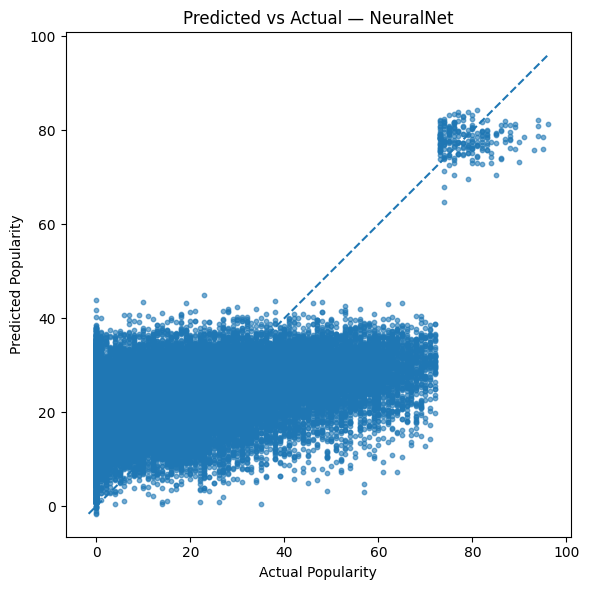

In [41]:
nn_pred = nn.predict(X_test_scaled, verbose = 0).ravel()
nn_R2 = round(float(r2_score(y_test, nn_pred)), 4)
nn_MAE = round(float(mean_absolute_error(y_test, nn_pred)), 4)
nn_RMSE = round(float(mean_squared_error(y_test, nn_pred)), 4)

print(f"NeuralNet -> R2: {nn_R2:.4f} | MAE: {nn_MAE:.4f} | RMSE: {nn_RMSE:.4f}")

results["NeuralNet"] = {"R2": nn_R2, "MAE": nn_MAE, "RMSE": nn_RMSE}
fitted_models["NeuralNet"] = (nn, nn_pred)

results_df = (
    pd.DataFrame(results).T.sort_values("RMSE").reset_index().rename(columns={"index": "Model"})
)
display(results_df)

results_df.to_csv(MET_DIR / "model_comparison.csv", index=False)
with open(MET_DIR / "model_comparison.json", "w") as f:
    json.dump(results, f, indent=2)

plt.figure(figsize=(6,6))
plt.scatter(y_test, nn_pred, s=10, alpha=0.6)
lims = [min(y_test.min(), nn_pred.min()), max(y_test.max(), nn_pred.max())]
plt.plot(lims, lims, linestyle="--")
plt.xlabel("Actual Popularity"); plt.ylabel("Predicted Popularity")
plt.title("Predicted vs Actual — NeuralNet")
plt.tight_layout()
plt.savefig(FIG_DIR / "pred_vs_actual_NeuralNet.png", dpi=200)
plt.show()

pd.DataFrame({"y_test": y_test.values, "y_pred": nn_pred}).to_csv(
    MET_DIR / "predictions_NeuralNet.csv", index=False
)

**Permutation**

Saved permutation importance -> C:\DS\spotify-MRS\artifacts\metrics\permutation_importance_NeuralNet.csv


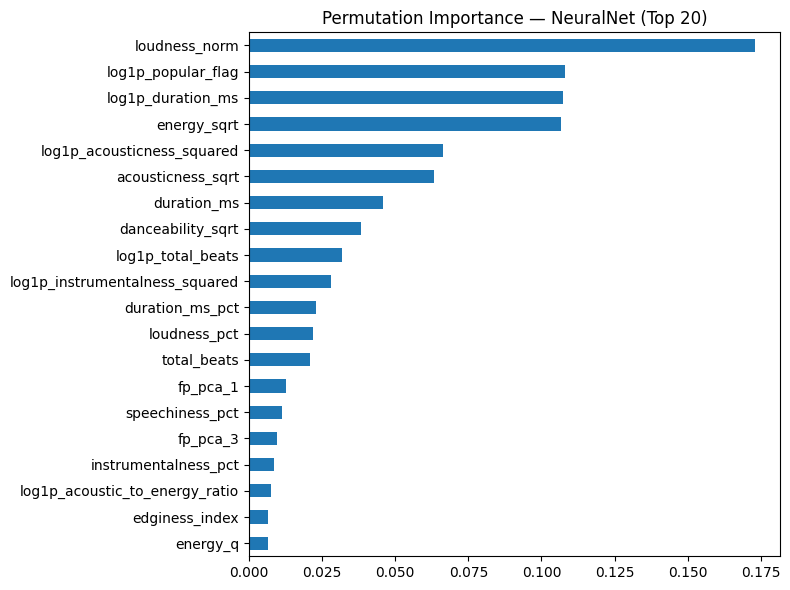

In [50]:
class KerasRegressorShim(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, X, y = None):
        self.is_fitted_ = True
        return self
    def predict(self, X):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        return self.model.predict(X, verbose=0).ravel()

shim = KerasRegressorShim(nn).fit(X_train_scaled, y_train)

perm = permutation_importance(
    estimator = shim,
    X = X_test_scaled,
    y = y_test.values,
    n_repeats = 8,
    random_state = 42,
    scoring = "r2",
    n_jobs = -1
)
pi = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
pi_top = pi.head(20)

out_csv = MET_DIR / "permutation_importance_NeuralNet.csv"
pi.to_csv(out_csv, header=["importance"])
print("Saved permutation importance ->", out_csv)

plt.figure(figsize=(8,6))
pi_top.sort_values().plot(kind="barh")
plt.title("Permutation Importance — NeuralNet (Top 20)")
plt.tight_layout()
plt.savefig(FIG_DIR / "permutation_importance_NeuralNet.png", dpi=200)
plt.show()

**Model Card**

In [54]:
model_card = {
  "dataset": ".../spotify_features_final.csv",
  "n_features": 85,
  "models_evaluated": ["Ridge", "RandomForest", "NeuralNet"],
  "best_model": "NeuralNet",
  "best_metrics": {"R2": 0.78, "MAE": 4.32, "RMSE": 5.47},
  "artifacts": {
    "scaler": ".../scaler.joblib",
    "best_model_file": ".../NeuralNet.keras",
    "comparison_csv": ".../model_comparison.csv",
    "pred_vs_actual_fig": ".../pred_vs_actual_NeuralNet.png",
    "nn_train_loss": ".../nn_train_val_loss.png",
    "nn_train_mae": ".../nn_train_val_mae.png"
  }
}
with open(MET_DIR / "model_card.json", "w") as f:
    json.dump(model_card, f, indent=2)
print("Saved model_card ->", MET_DIR / "model_card.json")
display(pd.Series(model_card["best_metrics"]))

Saved model_card -> C:\DS\spotify-MRS\artifacts\metrics\model_card.json


R2      0.78
MAE     4.32
RMSE    5.47
dtype: float64

**Song Similarity Engine**

In [69]:
TAB_DIR = ART_DIR / "tables"
SSE_DATA_CSV = ROOT / "data" / "clean_data" / "spotify_features_with_info.csv"

for d in [TAB_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

df_sse = pd.read_csv(SSE_DATA_CSV)
scalersse = joblib.load(MODELS_DIR / "scaler.joblib")

exclude_cols = {"popularity", "popular_flag", "track_name", "artist_name"}
feature_cols = [c for c in df_sse.columns if c not in exclude_cols and pd.api.types.is_numeric_dtype(df_sse[c])]
print("Num features used for similarity:", len(feature_cols))

Num features used for similarity: 50


In [70]:
X_all = df_sse[feature_cols].copy()
X_all_scaled = scaler.transform(X_all)
print("Scaled matrix shape:", X_all_scaled.shape)

name_col = "track_name" if "track_name" in df_sse.columns else None
artist_col = "artist_name" if "artist_name" in df_sse.columns else None

Scaled matrix shape: (130326, 50)


In [71]:
def _row_mask_from_text(df, col, text):
    if col is None or text is None or not isinstance(text, str):
        return np.zeros(len(df), dtype = bool)
    return df[col].fillna("").str.contains(text, case = False, regex = False)

def _safe_mean(vectors):
    return vectors.mean(axis = 0) if vectors.shape[0] > 0 else None

def get_track_vector(track_query, artist_query = None):
    mask = _row_mask_from_text(df_sse, name_col, track_query) if name_col else np.zeros(len(df_all), dtype=bool)
    if artist_query and artist_col:
        mask &= _row_mask_from_text(df_sse, artist_col, artist_query)
    index = np.where(mask)[0]
    if len(index) == 0:
        return None, None
    i = int(index[0])
    vec = X_all_scaled[i: i + 1]
    return i, vec